# IPD et Machine learning

Auteur : Philippe Mathieu, CRISTAL Lab, SMAC Team, University of Lille, email : philippe.mathieu@univ-lille.fr

Contributeurs : Louisa Fodil (CRISTAL/SMAC), Céline Petitpré (CRISTAL/SMAC)

Creation : 18/01/2018

## Introduction

Le Dilemme itéré du prisonnier permet d'exprimer une infinité de stratégies. Il est naturel de se demander laquelle est la meilleure ? Malheureusement il n'y a pas de stratégie meilleure dans l'absolu. On ne peut par exemple pas jouer optimalement contre `All_D` et `Spiteful`. Ceci est du au fait qu'il s'agit d'un jeu simultané, et qu'au premier coup, on ne connait pas encore son adversaire. Il faut donc choisir. Il y a par contre des stratégie plus "robustes" que d'autres, au sens où elles sont toujours efficaces dans des environnements variés.
Les compétitions écologiques et les sous-classes sont des moyens de faire varier légèrement l'environnement.
Reste maintenant à trouver de bonnes stratégies.
Nous cherchons ici à savoir quels sont les outils qui nous permettent d'identifier de nouvelles stratégies robustes et notamment si les techniques d'Intelligence Artificielles peuvent nous être utiles pour les mettre en évidence.

Dans ce notebook nous considérons comme acquis tous les outils précédemment créés et que nous savons évaluer un ensemble de stratégies par compétition écologique. 

In [2]:
# All about simultaneous games (class Game with getNash(), getPareto(), getDominantStrategies())
%run ../src/Game.py

# All about ipd (Meeting, Tournament and Ecological classes)
%matplotlib inline
%run ../src/ipd.py

# All about strategies (getPeriodics(n), getMem(X,Y), getClassicals())
%run ../src/strategies.py

# Commebnt on fait un tournoi, comment on affiche la matrice, comment on connait le vainqueur et idem pour compet ecolo

# Apprendre des stratégies

A partir d'ici on considère qu'on sait faire des tournois , compétitions et sous-classes
et qu'on a a disposition des ensembles de stratégies définies avec génotype. Ce qu'on cherche, c'est trouver des bonnes stratégies
- methodes de monte carlo
- algos génétiques
- et tout ce que l'on peut faire de mieux (jouer sur les fonctions de fitness , faire du reinforcement learning, des reseaux de neurones etc ...)

# Methode de Monte-Carlo

## Battre une classe mem
Il est très souvent (toujours ?) possible de trouver une stratégie capable de battre toutes celles d'une classe donnée dans une classe d'ordre supérieur. Par exemple trouver une `Mem(2,2)` capable de gagner dans l'ensemble des `Mem(1,1)`. La manière la plus simple d'en trouver une consiste à calculer un certain nombre de fois un génotype aléatoire d'une `Mem(2,2)`, de l'évaluer dans `Mem(1,1)`, de regarder son classement et de ne conserver que celle qui a obtenu le meilleur classement. C'est le cas de `Mem(2,2,'CCCCDDDCCDCDDDDDDD')`.

In [3]:
class FindBest:
    def __init__(self, game):
        self.game = game

    def generate_random_genotype(self, x, y):
        N = max(x,y) + 2**(x+y)
        genotype = ""
        for i in range (N):
            genotype += random.choice(self.game.actions)
        return genotype

    def random_selection(self, x, y, nb_tests, soupe):
        d = dict()
        for n in range(nb_tests):
            genotype = self.generate_random_genotype(x,y)
            strat = Mem(x,y,genotype)
            eco = Ecological(self.game, soupe+[strat])
            eco.run()
            d[genotype] = eco.historic.columns.tolist().index(strat.name)
        return sorted(d.items(), key=lambda t: t[1])


dip =[(3,3),(0,5),(5,0),(1,1)]
g = Game.Game(dip,['C','D'])
gen = FindBest(g)
soupe = getMem(1,1)
print(gen.random_selection(2,2,10,soupe)[1:3])

[('CCDCDDCCDCDDDDCDCD', 4), ('DDDDCDDDDDDDCCDDDC', 12)]


### Evaluation de la stratégie trouvée précédemment

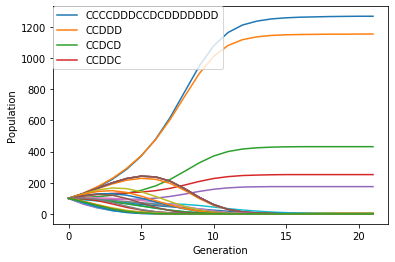

CCCCDDDCCDCDDDDDDD    1267
CCDDD                 1153
CCDCD                  431
CCDDC                  252
CCDCC                  175
CCCCC                    5
CCCCD                    5
CCCDC                    5
CCCDD                    5
Name: 21, dtype: object


In [5]:
bag3=getMem(1,1)
e2=Ecological(g,bag3+[Mem(2,2,'CCCCDDDCCDCDDDDDDD')])
e2.run()
e2.drawPlot(None,4)
evol=e2.historic
print(evol.iloc[-1][evol.iloc[-1]>0])

### Mais à cause de l'overfitting, elle est peu robuste

In [8]:
# Pour mesurer la robustesse, on regarde le classement de cette stratégie dans les sous-classes de taille n-1.
subClassesWithOneStrat(bag3, len(bag3)-1 , Mem(2,2,'CCCCDDDCCDCDDDDDDD'))

Classement de la stratégie : CCCCDDDCCDCDDDDDDD
Meilleure place    1.000000
Pire place         2.000000
RankAvg            1.031250
RankStd            0.176777
Name: CCCCDDDCCDCDDDDDDD, dtype: float64


([<__main__.Mem at 0x110a53610>,
 <__main__.Mem at 0x121f12810>)

## Algo Génétique

Les techniques de Monte-Carlo sont simples à comprendre mais lentes à converger. Les algorithmes génétiques sont bien plus performants pour ce type de rechercher. ON peut par exemple utiliser la librairie [Deap](https://deap.readthedocs.io/en/master/).

Un algo génétique a pour objectif de trouver un bon génotype dans un ensemble des phénotypes possible. Il démarre initialement d'une liste de taille fixée, d'individus pris au hasard. Il effectue plusieurs tours de calculs à partir de cette liste. A chaque tour, il élimine de la liste les individus les plus mauvais calculés selon une fonction de fitness (`xxxx`). Il complète alors sa liste avec de nouveaux individus obtenus à l'aide de deux opérations élémentaires : la mutation (`xxx`) et le crossing over (`xxx`) pour toujours avoir une liste de même taille.


In [18]:
import math
from deap import creator, base, tools, algorithms
import random
import time

class Genetic:

    def __init__(self, game, x, y, soupe):
        self.game = game
        self.x = x
        self.y = y
        self.soupe = soupe


    def createEnv(self):
        creator.create("FitnessMax", base.Fitness, weights=(-1.0,)) #-1.0 in order to minimize , 1.0 to maximize
        creator.create("Individual", list, fitness=creator.FitnessMax)
        toolbox = base.Toolbox()
        toolbox.register("random_action", random.choice, "CD")
        DIM = max(self.x,self.y) + 2**(self.x+self.y)
        toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.random_action, n=DIM)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)
        toolbox.register("mate", tools.cxTwoPoint)
        toolbox.register("select", tools.selBest)
        toolbox.register("evaluate", self.evaluateInd)
        toolbox.register("mutate", self.myMutation)
        return toolbox


    
    def runEvolutionnary(self, toolbox, pop, parents, children):
        """
        parents : The number of individuals to select for the next generation.
        children : The number of children to produce at each generation.
        """
        # The probability that an offspring is produced by crossover.
        cxpb = 0.8
        # The probability that an offspring is produced by mutation.
        mutpb = 0.05
        # The number of generation.
        ngen = 1
        pop = toolbox.population(n=pop)
        fit = math.inf
        while (fit > 1):
            algorithms.eaMuPlusLambda(pop, toolbox, parents, children, cxpb, mutpb, ngen)
            # The algo stops when one individual becomes first in the Ecological ranking (in soup)
            top = sorted(pop, key=lambda x:x.fitness.values[0])[-1]
            fit = top.fitness.values[0]
            print('Classement : '+str(int(fit)))
        print('Stratégie gagnante : '+self.__str__(top))
        return self.__str__(top)


    def __str__(self,individual):
        s = ""
        for i in range(len(individual)):
            s += individual[i]
        return s


    def evaluateInd(self, individual):
        genotype = self.__str__(individual)
        strat = Mem(self.x, self.y, genotype)
        eco = Ecological(self.game, self.soupe+[strat],  length=100)
        eco.run()
        return (float(eco.historic.columns.tolist().index(strat.name)+1),)


    def myMutation(self, individual):
        return (individual,)


ModuleNotFoundError: No module named 'deap'

### Un exemple simple et rapide : trouver parmi Mem(1,1) une stratégie qui bat toujours "Gentille" et "Méchante" en compétition écologique 

In [10]:
dip =[(3,3),(0,5),(5,0),(1,1)]   # Dilemme du prisonnier
g = Game.Game(dip,['C','D'])
soupe = [Periodic("C"),Periodic("D")]
gen = Genetic(g,1,1,soupe)
toolbox = gen.createEnv()
t = time.time()
gagnante = gen.runEvolutionnary(toolbox, 25, 12, 8)
t2 = time.time()
print("Le temps d'éxécution est de " + str(t2-t) + " secondes")

NameError: name 'Genetic' is not defined

#### On peut maintenant vérifier avec un graphe que la stratégie est bien gagnante

In [ ]:
e = Ecological(g, soupe+[Mem(1,1,gagnante)])
e.run()
e.drawPlot()

### Trouver la meilleure stratégie Mem(1,2) qui bat toutes les stratégies de Mem(1,1) (execution > 4H)
Par exemple Mem(1,2,"CCCCDDDDDD")

In [ ]:
dip =[(3,3),(0,5),(5,0),(1,1)]   # Dilemme du prisonnier
g = Game.Game(dip,['C','D'])
soupe = getMem(1,1)
gen = Genetic(g,1,2,soupe)
toolbox = gen.createEnv()
t = time.time()
gen.runEvolutionnary(toolbox, 25, 12, 8)
t2 = time.time()
print("Le temps d'éxécution est de " + str(t2-t) + " secondes")

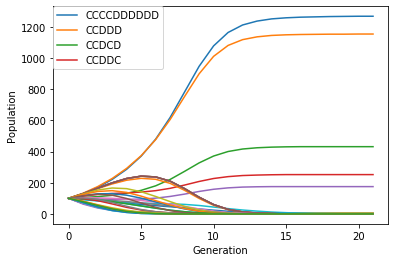

In [14]:
#Ici je vérifie et montre le résultat de l'algorithme génétique car l'algorithme génétique prends beaucoup de temps
soupe = getMem(1,1)
e = Ecological(g, soupe+[Mem(1,2,"CCCCDDDDDD")])
e.run()
e.drawPlot(None,4)

### Trouver la meilleure stratégie Mem(2,1) qui bat toutes les stratégies de Mem(1,1)(execution > 4H)

In [ ]:
dip =[(3,3),(0,5),(5,0),(1,1)]   # Dilemme du prisonnier
g = Game.Game(dip,['C','D'])
soupe = getMem(1,1)
gen = Genetic(g,2,1,soupe)
toolbox = gen.createEnv()
t = time.time()
gen.runEvolutionnary(toolbox, 25, 12, 8)
t2 = time.time()
print("Le temps d'éxécution est de " + str(t2-t) + " secondes")

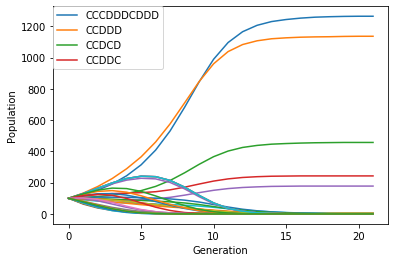

In [15]:
#Ici je vérifie et montre le résultat de l'algorithme génétique car l'algorithme génétique prends beaucoup de temps
soupe = getMem(1,1)
e = Ecological(g, soupe+[Mem(2,1,"CCCDDDCDDD")])
e.run()
e.drawPlot(None,4)

### Trouver la meilleure stratégie Mem(2,2) qui bat toutes les stratégies de Mem(1,1)(execution > 24H)

In [ ]:
dip =[(3,3),(0,5),(5,0),(1,1)]   # Dilemme du prisonnier
g = Game.Game(dip,['C','D'])
soupe = getMem(1,1)
gen = Genetic(g,2,2,soupe)
toolbox = gen.createEnv()
t = time.time()
gen.runEvolutionnary(toolbox, 25, 12, 8)
t2 = time.time()
print("Le temps d'éxécution est de " + str(t2-t) + " secondes")

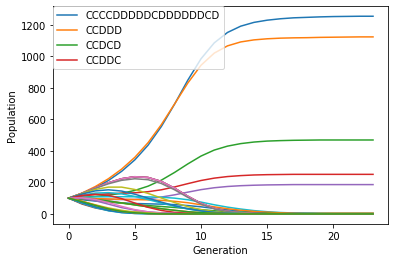

In [17]:
#Ici je vérifie et montre le résultat de l'algorithme génétique car l'algorithme génétique prends beaucoup de temps
soupe = getMem(1,1)
e = Ecological(g, soupe+[Mem(2,2,"CCCCDDDDDCDDDDDDCD")])
e.run()
e.drawPlot(None,4)

Encore une fois les stratégies trouvées pour surperformer contre une classe donnée sont particulièrement bien adaptées à cette classe mais très peu robustes. En changeant ne serait-ce qu'une stratégie dans l'ensemble initiale, elles ne surperforment plus.
On étudie ici une stratégie obtenue par algorithme génétique face à toutes les sous-classes de taille (n-1)

In [ ]:
# On cherche une stratégie gagnante dans Mem(1,1) qui bat gentille, méchante et softmajority.
dip =[(3,3),(0,5),(5,0),(1,1)]   # Dilemme du prisonnier
g = Game.Game(dip,['C','D'])
soupe = [Periodic("C"),Periodic("D"), SoftMajority()]
gen = Genetic(g,1,1,soupe)
toolbox = gen.createEnv()
gagnante = gen.runEvolutionnary(toolbox, 25, 12, 8)


In [ ]:
# On regarde le classement de la stratégie gagnante trouvée dans les sous-classes de taile n-1.
subClassesWithOneStrat(soupe, 2, Mem(1,1,gagnante))

On voit ici que la stratégie gagnante a une pire place égale à 2, ce qui montre bien qu'elle ne gagne pas tout le temps.
On a fait de l'"overfitting".

## Approche neuronale (Caffe ? TensorFlow ? Keras ?)

# Bibliographie

- Robert Axelrod, The Evolution of Cooperation (New York: Basic Books, 1984).
- JP Delahaye et P Mathieu. Des surprises dans le monde de la coopération. Pour la Science, numéro spécial "Les mathématiques sociales", pp 58-66, Juillet 1999.
- Philippe Mathieu, Jean-Paul Delahaye. [New Winning Strategies for the Iterated Prisoner's Dilemma](http://jasss.soc.surrey.ac.uk/20/4/12.html). J. Artificial Societies and Social Simulation 20(4) (2017)
- Philippe Mathieu, Jean-Paul Delahaye. New Winning Strategies for the Iterated Prisoner's Dilemma. AAMAS 2015: 1665-1666
- Bruno Beaufils, Jean-Paul Delahaye et Philippe Mathieu. Our Meeting with Gradual : A good Strategy for the Itareted Prisoner’s Dilemma, in Intern. Cof. on Artificial Life V (ALIFE V), pp. 159- 165, 16-18 mai 1996, Nara (Japon).
- Martin Nowak et K. Sigmund, TIT for TAT in Heterogeneous Populations, Nature, vol. 355, n° 16, pp. 250-253, janvier 1992.